In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
from tensorflow.contrib.rnn import LSTMCell, LSTMStateTuple

In [2]:
tf.__version__

'1.8.0'

In [3]:
PAD = 0
EOS = -1

encoder_hidden_units = 40
decoder_hidden_units = encoder_hidden_units * 2
input_dim = 3
output_dim = 1
encoder_lengths = 23
decoder_lengths = 17

BATCH_SIZE = 64

In [4]:
nonshuffled_encoder_input = np.load('./npy/seq2seq/encoder_input.npy')
nonshuffled_decoder_target = np.load('./npy/seq2seq/decoder_target.npy')

encoder_input = np.load('./npy/seq2seq/shuffled_encoder_input.npy')
decoder_target = np.load('./npy/seq2seq/shuffled_decoder_target.npy')

real_target = np.load('./npy/real_target_seq.npy')

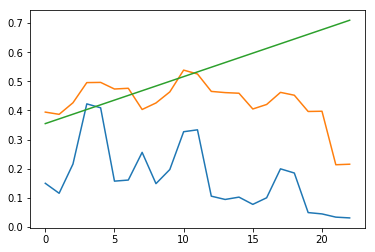

In [5]:
plt.plot(real_target[0])

In [6]:
encoder_input.shape, decoder_target.shape

((23000, 23, 3), (23000, 17, 1))

In [7]:
# train_encoder_input = nonshuffled_encoder_input[1000:2000]
# train_decoder_target =  nonshuffled_decoder_target[1000:2000]

In [8]:
# train_size = int(len(encoder_input) * 0.8)
train_size = (len(encoder_input)//BATCH_SIZE - 2) * BATCH_SIZE

train_encoder_input = encoder_input[:train_size]
test_encoder_input = encoder_input[train_size:]
train_decoder_target = decoder_target[:train_size]
test_decoder_target = decoder_target[train_size:]

print(train_encoder_input.shape)
print(test_encoder_input.shape)

(22848, 23, 3)
(152, 23, 3)


In [9]:
tf.reset_default_graph()


encoder_inputs = tf.placeholder(shape=(encoder_lengths, None, input_dim), dtype=tf.float32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(decoder_lengths, None, output_dim), dtype=tf.float32, name='decoder_targets')


encoder_cell = LSTMCell(encoder_hidden_units)

((encoder_fw_outputs,
  encoder_bw_outputs),
 (encoder_fw_final_state,
  encoder_bw_final_state)) = (
    tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                    cell_bw=encoder_cell,
                                    inputs=encoder_inputs,
                                    dtype=tf.float32, time_major=True)
    )

encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)

encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)

encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)

encoder_final_state = LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
)


decoder_cell = LSTMCell(decoder_hidden_units)

encoder_max_time, batch_size, _ = tf.unstack(tf.shape(encoder_inputs))

W = tf.Variable(tf.random_uniform([decoder_hidden_units, output_dim], -1, 1), dtype=tf.float32)
b = tf.Variable(tf.zeros([output_dim]), dtype=tf.float32)


assert EOS == -1

eos_time_slice = tf.ones([batch_size, output_dim], dtype=tf.float32, name='EOS')


def loop_fn_initial():
    initial_elements_finished = (0 >= decoder_lengths)  # all False at the initial step
    initial_input = eos_time_slice
    initial_cell_state = encoder_final_state
    initial_cell_output = None
    initial_loop_state = None  # we don't need to pass any additional information
    return (initial_elements_finished,
            initial_input,
            initial_cell_state,
            initial_cell_output,
            initial_loop_state)

def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):

    def get_next_input():
        output_logits = tf.add(tf.matmul(previous_output, W), b)
        next_input = output_logits

        return next_input
    
    elements_finished = (time >= decoder_lengths) # this operation produces boolean tensor of [batch_size]
                                                  # defining if corresponding sequence has ended

    finished = tf.reduce_all(elements_finished) # -> boolean scalar
    input = tf.cond(finished, lambda: eos_time_slice, get_next_input)
    state = previous_state
    output = previous_output
    loop_state = None

    return (elements_finished, 
            input,
            state,
            output,
            loop_state)


def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:    # time == 0
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)

decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, output_dim))

decoder_prediction = decoder_logits

loss = tf.losses.mean_squared_error(decoder_targets, decoder_logits)

train_op = tf.train.AdamOptimizer().minimize(loss)

In [12]:
train_loss = []
test_rmse = []

epoch = 10
iters = len(train_encoder_input)//BATCH_SIZE

saver = tf.train.Saver()
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)    
    
#     saver.restore(sess, "./tmp/seq2seq/model40_nonpad_23000.ckpt")

    for epoch_ in range(epoch):
        for i in range(iters):
            start = i*BATCH_SIZE
            end = start+BATCH_SIZE
            
            feed_input = train_encoder_input[start:end].transpose((1,0,2))
            feed_target = train_decoder_target[start:end].transpose((1,0,2))
            
            fd = {encoder_inputs: feed_input, decoder_targets: feed_target}
            _, l = sess.run([train_op, loss], fd)


        rmse = np.sqrt(sess.run(loss, feed_dict={encoder_inputs: test_encoder_input.transpose((1,0,2)),
                                                 decoder_targets: test_decoder_target.transpose((1,0,2))}))    
        train_loss.append(l)
        test_rmse.append(rmse)


        print('epoch {}'.format(epoch_))
        
    
    predict_ = sess.run(decoder_prediction, feed_dict={encoder_inputs: test_encoder_input.transpose((1,0,2))})
#     predict_ = sess.run(decoder_prediction, feed_dict={encoder_inputs: nonshuffled_encoder_input[1000:1100].transpose((1,0,2))})

    
    predict_real = sess.run(decoder_prediction, feed_dict={encoder_inputs: real_target.transpose((1,0,2))})
    
    save_path = saver.save(sess, "./tmp/seq2seq/model40_nonpad_23000.ckpt")
    print("Model saved in path: %s" % save_path)

    

epoch 0
epoch 1
epoch 2


KeyboardInterrupt: 

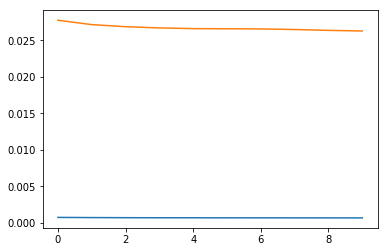

In [370]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(test_rmse)

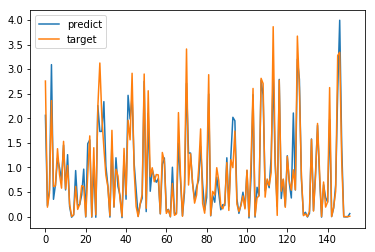

In [372]:
plt.plot(predict_.sum(axis=0), label='predict')
plt.plot(test_decoder_target.sum(axis=1), label='target')
plt.legend()

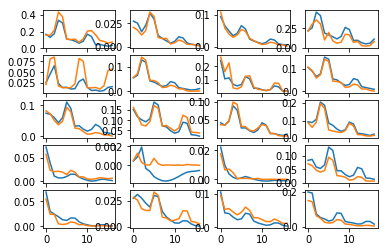

In [373]:
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.plot(predict_[:,i])
    plt.plot(test_decoder_target[i])    


In [374]:
scaler = pickle.load(open('./scaler/scaler_target_seq.sav', 'rb'))
predict = predict_real.transpose((1,0,2))
inv_predict = scaler.inverse_transform(predict.reshape(-1,3)).reshape((3,17,1))
inv_predict.sum(1)

c:\users\10user\appdata\local\programs\python\python36\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


array([[ 176543.45  ],
       [  -4805.2817],
       [1042839.2   ]], dtype=float32)